# Credit Card Fraud Detection

__Goal:__ 

Predict the probability of an online credit card transaction being fraudulent, based on different properties of the transactions. 


## 1. Setup Environment

The goal of this section is to:
- Import all the packages
- Set the options for data visualizations

other dataset: 
https://www.openml.org/search?type=data&status=active&id=45036&sort=runs


In [2]:
# Data Manipulation
import numpy as np 
import pandas as pd 

# Data Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Time
import time
import datetime


# Machine Learning
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
#plot_roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import minmax_scale

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# imbalanced learning (more on this later)
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import chi2_contingency,  f_oneway

import gc
import warnings
from tqdm import tqdm

# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
warnings.filterwarnings("ignore")

Upload the zip file into the left column. Then unzip it;

Good practice to use zip files to speed things up. Also Colab is not run on your own environment (local computer). 

When you do command line, be sure that you specify "!"

In [3]:
!unzip /content/dataset.parquet.zip

Archive:  /content/dataset.parquet.zip
  inflating: dataset.parquet         
  inflating: __MACOSX/._dataset.parquet  


## 2. Data Overview

Purpose is to:

1. Load the dataset
2. Explore the features

**Note:** Not all transactions have corresponding identity information.

Load the transaction and identity datasets using pd.read_csv(), but for the sake of time, we use pd.read_parquet().

Whenever you have a data file with more than a few thousand rows, don't use pd.read_csv(); too slow and kills progress

In [4]:
%%time
# Load Data
"""
df = pd.read_csv('/content/creditcard.csv')
df.to_parquet('/content/dataset.parquet') 
"""
# save time (b/c csv is very slow)

# load into the left side with the parquet file 
df = pd.read_parquet('/content/dataset.parquet')
df.head()

CPU times: user 5.66 s, sys: 5.53 s, total: 11.2 s
Wall time: 6.31 s


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0          None          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com          None  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15    M1    M2    M3    M4    M5    M6  \
0  13.0   13.0  NaN  NaN  NaN    0.0     T     T     T    M2     F     T   
1   0.0    NaN  NaN  NaN  NaN    0.0  None  None  None    M0     T     T   
2   0.0  315.0  NaN  NaN  NaN  315.0     T     T     T    M0     F     F   
3  84.0    NaN  NaN  NaN  NaN  111.0  None  None  None    M0     T     F   
4   NaN    NaN  NaN  NaN  NaN    NaN  None  None  None  None  None  None   

     M7    M8    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  \
0  None  None  None  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
1  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2     F     F     F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
3  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  1

In [ ]:
# add the parquet file

#df = pd.read_parquet("/content/credit.parquet")

In [ ]:
# Identitiy Data
df.head(10) # 10 rows

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   
5  555.0  150.0        visa  226.0   debit  272.0   87.0   36.0    NaN   
6  360.0  150.0        visa  166.0   debit  126.0   87.0    0.0    NaN   
7  490.0  150.0        visa  226.0   debit  325.0   87.0    NaN    NaN   
8  100.0  150.0        visa  226.0   debit  337.0   87.0    NaN    NaN   
9  111.0  150.0  mastercard  224.0   debit  204.0   87.0   19.0    NaN   

   P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           None          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1      gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2    outlook.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3      yahoo.com          None  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4      gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
5      gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
6      yahoo.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
7       mail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
8  anonymous.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
9      yahoo.com          None  2.0  2.0  0.0  0.0  0.0  3.0  0.0  0.0  3.0   

   C10  C11  C12   C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0    NaN   NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   94.0   0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    NaN   NaN NaN NaN NaN NaN   
5  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
6  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
7  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    0.0   NaN NaN NaN NaN NaN   
8  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN    NaN   NaN NaN NaN NaN NaN   
9  0.0  1.0  0.0  12.0  2.0   61.0   61.0  30.0  318.0  30.0 NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15    M1    M2    M3    M4    M5    M6  \
0  13.0   13.0  NaN  NaN  NaN    0.0     T     T     T    M2     F     T   
1   0.0    NaN  NaN  NaN  NaN    0.0  None  None  None    M0     T     T   
2   0.0  315.0  NaN  NaN  NaN  315.0     T     T     T    M0     F     F   
3  84.0    NaN  NaN  NaN  NaN  111.0  None  None  None    M0     T     F   
4   NaN    NaN  NaN  NaN  NaN    NaN  None  None  None  None  None  None   
5   0.0    0.0  NaN  NaN  NaN    0.0     T     T     T    M1     F     T   
6   0.0    0.0  NaN  NaN  NaN    0.0     T     T     T   

Shape of data

In [ ]:
print(df.shape)

(590540, 434)


Whenever you use a package / library, have to install first 

!pip install --upgrade package_name

In [ ]:
!pip install pandas_summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 KB 4.5 MB/s eta 0:00:00


In [ ]:
"""
from pandas_summary import DataFrameSummary


df_summary = DataFrameSummary(df)
df_summary.summary()
"""

'\nfrom pandas_summary import DataFrameSummary\n\n\ndf_summary = DataFrameSummary(df)\ndf_summary.summary()\n'

The above took a real long time! But, it still might be more efficient than writing a for-loop to do things step by step

In [6]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1175.65 Mb (52.7% reduction)


All numeric columns, meaning we don't need to do anything with text data

Get a sense of the distribution of target variable

In [ ]:
df.loc[:, 'isFraud'].value_counts()
# this is to see how many are each class 

0    569877
1     20663
Name: isFraud, dtype: int64

Arrange things more nicely

In [ ]:
class_distrib = pd.DataFrame(df.isFraud.value_counts().reset_index()) # use df["col_name"] or df.col_name to refer to a specific column
# the .reset_index() is needed to make the format nice; otherwise, it's just a mess and columns don't line up
class_distrib.columns = ['class', "count"]
class_distrib

class   count
0      0  569877
1      1   20663

In [ ]:
# Drop the columns where one category contains more than 90% values
drop_cols = [] # list data structure

# create a for-loop to run through
for col in df.columns: 
    missing_share = df[col].isnull().sum()/df.shape[0]
    if missing_share > 0.9:
        drop_cols.append(col)
        print(col)
        # df[col + "_missing_flag"] = df[col].isnull()
    
good_cols = [col for col in df.columns if col not in drop_cols] # don't want to drop / or keep

dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27


An idea: maybe it's good to have some functions in place for future reference. We will define a function now as follows:

In [ ]:
"""
def my_function(param 1, ..., param n):

  # write your function. 
  # Tips: start with some basic structures like lists or dictionaries or some numbers (usually empty or set to 0) 
  # which you will update in a loop or more loops and then return it

  # initalize some variable 
  # (ie) x = 0

  # for i in range(len()) or some_number or df.columns or df.col_name:
    # do something

  # return that variable
"""

'\ndef my_function(param 1, ..., param n):\n\n  # write your function. \n  # Tips: start with some basic structures like lists or dictionaries or some numbers (usually empty or set to 0) \n  # which you will update in a loop or more loops and then return it\n\n  # initalize some variable \n  # (ie) x = 0\n\n  # for i in range(len()) or some_number or df.columns or df.col_name:\n    # do something\n\n  # return that variable\n'

In [ ]:
def drop_cols_with_much_missing_values(df):
  drop_cols = [] # list data structure
  # create a for-loop to run through
  for col in df.columns: 
      missing_share = df[col].isnull().sum()/df.shape[0]
      if missing_share > 0.9:
          drop_cols.append(col)
          print(col)
          # df[col + "_missing_flag"] = df[col].isnull()
  good_cols = [col for col in df.columns if col not in drop_cols] # list comprehension [i for i in sth if <condition> else <sth>]
  return good_cols # return sth

In [ ]:
good_cols = drop_cols_with_much_missing_values(df)
print(f"here are the good_cols: {good_cols}")

dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27
here are the good_cols: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', '

### Basic Visualizations on the distribution

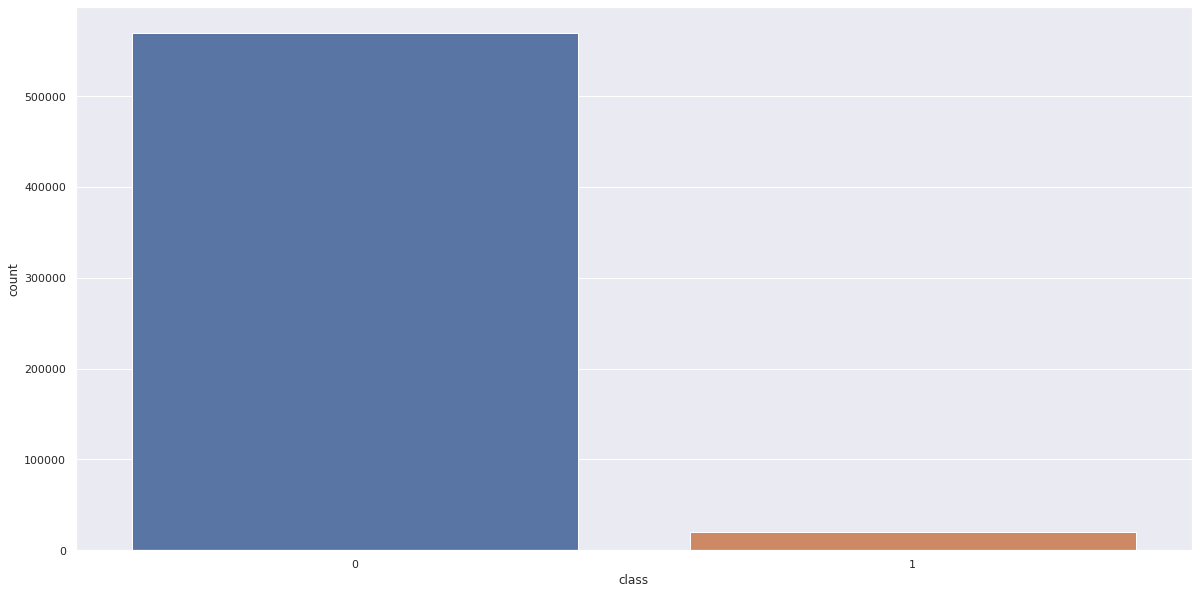

In [ ]:
sns.set(rc={"figure.figsize":(20, 10)}) # set the figure size to make things look bigger.
sns.barplot(data=class_distrib, x="class", y="count")
# sns.countplot()

This dataset has a big imbalance issue. This will be an issue moving forward, we want to be careful about which metircs to use to evaluate our machine learning model 

In [ ]:
pd.DataFrame(df.TransactionDT.value_counts().reset_index())

index  TransactionDT
0        9474817              8
1       11576951              5
2        4397066              5
3        7236588              5
4        1544629              4
...          ...            ...
573344   4629634              1
573345   4629631              1
573346   4629557              1
573347   4629466              1
573348  15811131              1

[573349 rows x 2 columns]

we do have a datetime column and we need to process it

In [ ]:
from datetime import datetime, timedelta

In [ ]:
# Date features

START_DATE         = '2017-12-01' 
# given that the start date is from this date forward. From above, the 8, 5, ..., 1 are 
startdate          = datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"]         = df['TransactionDT'].apply(lambda x: (startdate + timedelta(seconds=x)))
# adding time in seconds using the timedelta function inside another function we call lambda x: <expression>. 
# We then apply it to df.TransactionDT

# df.TransactionDT or df['TransactionDT']
# .apply() uses a function you define or stored in the library such as mean, min, max, to the column you specify

df['Weekdays']    = df['Date'].dt.dayofweek
df['Hours']       = df['Date'].dt.hour
df['Days']        = df['Date'].dt.day

In [ ]:
df.Days.value_counts()

3     24197
4     23223
2     21894
23    21265
24    21026
21    20358
5     20200
6     20095
20    19914
22    19675
13    19625
17    19617
25    19606
26    19563
19    19089
10    19074
14    19049
16    18839
9     18788
15    18784
7     18742
1     18264
18    18158
8     18117
12    17989
27    17946
11    17879
28    17662
30    15361
29    13379
31    13162
Name: Days, dtype: int64

In [ ]:
df.P_emaildomain.value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [ ]:
df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'

df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'

df.loc[df.P_emaildomain.isin(df.P_emaildomain\
                                         .value_counts()[df.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
                                         
df.P_emaildomain.fillna("NoInf", inplace=True)

In [ ]:
# Average fraud per transaction by Product CD

# groupby separates the data into different groups based on the value of that variable. (ex) variable called color. Within that, we have red, blue, green, yellow. THe groupby will make the data into 4 groups representing the 4 colors. 
df.groupby('ProductCD')['isFraud'].mean()

# 0 or 1. 

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

In [ ]:
# Average fraud per transaction by email domain

df.groupby('P_emaildomain')['isFraud'].mean() # .max() or .median() or .min()

P_emaildomain
Google            0.043496
Microsoft         0.053298
NoInf             0.029538
Others            0.025646
Yahoo Mail        0.022544
anonymous.com     0.023217
aol.com           0.021811
att.net           0.007439
bellsouth.net     0.027763
charter.net       0.030637
comcast.net       0.031187
cox.net           0.020818
earthlink.net     0.021401
icloud.com        0.031434
mail.com          0.189624
me.com            0.017740
optonline.net     0.016815
rocketmail.com    0.003012
sbcglobal.net     0.004040
verizon.net       0.008133
ymail.com         0.020868
Name: isFraud, dtype: float64

## EDA (visualizations)

### Count plots (distribution)

In [ ]:
def plot_cat_with_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))

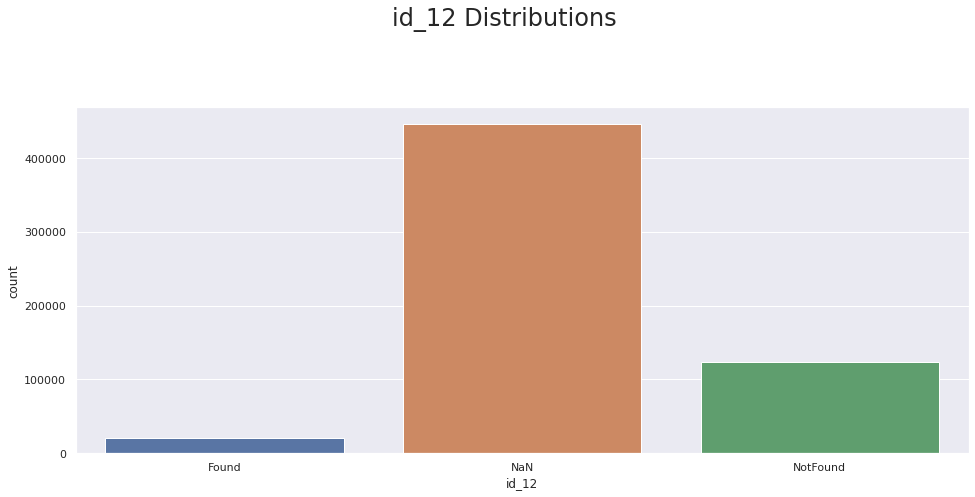

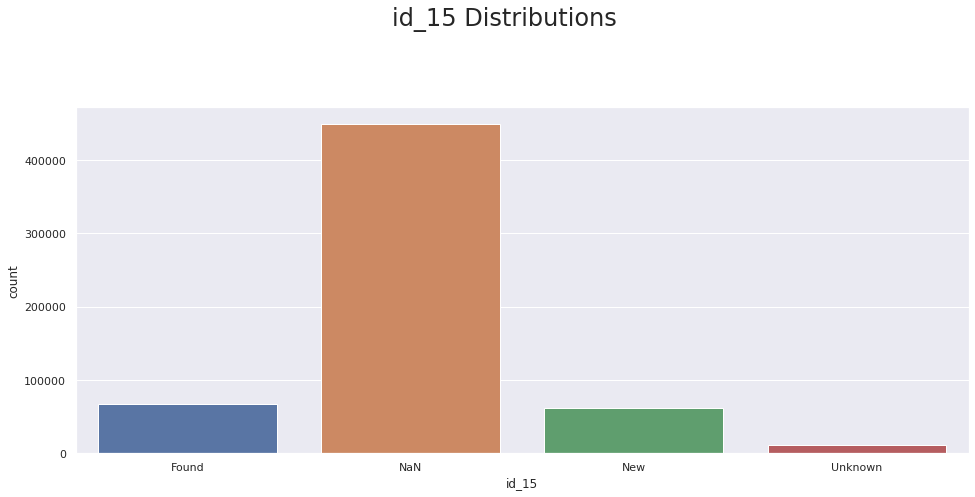

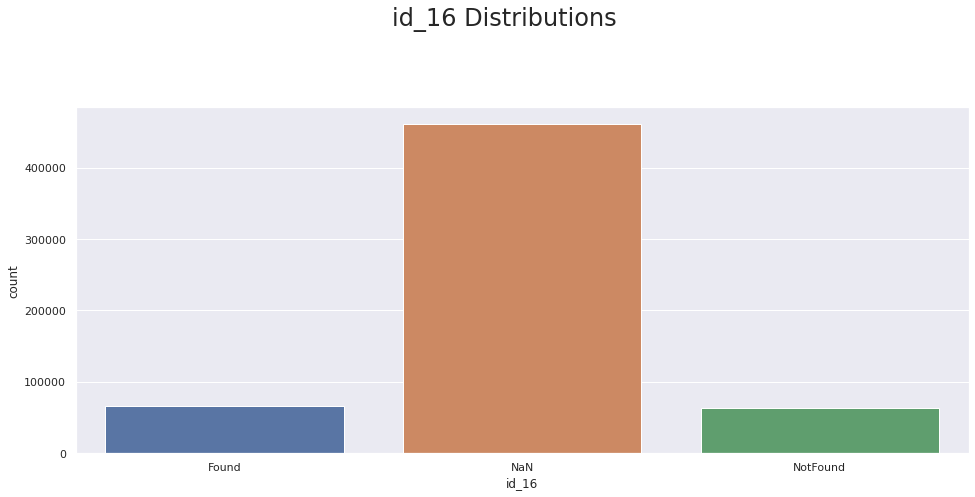

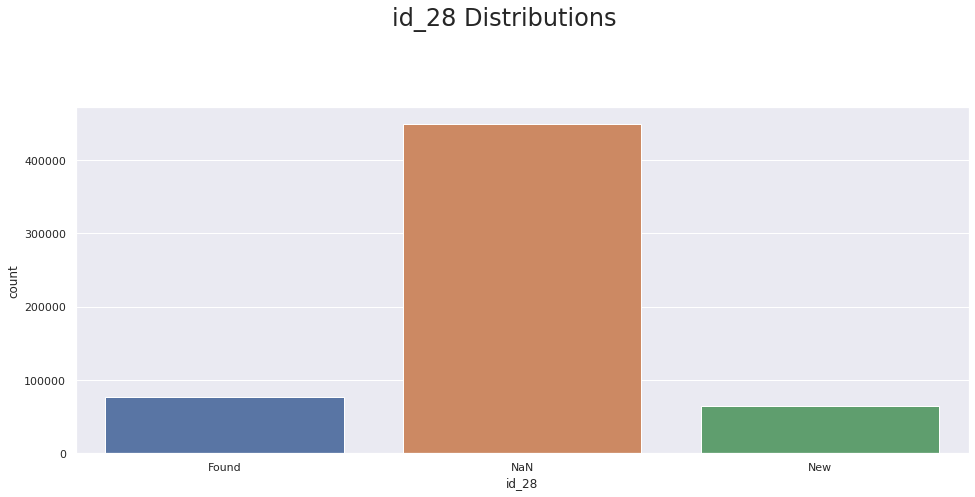

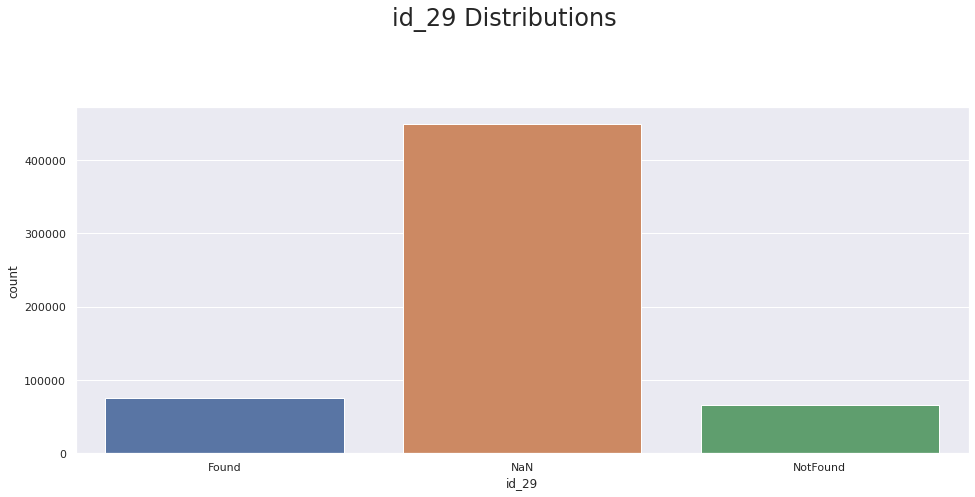

In [ ]:
# be sure to remove the null values (empty) with NaN before you do visualizations. 
for col in ['id_12', 'id_15', 'id_16', 'id_28', 'id_29']:
    df[col] = df[col].fillna('NaN') # or do df[col].fillna('NaN', inplace=True)
    plot_cat_with_amt(df, col)

In [ ]:
print(list(df.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

Do the same for the C, D, M, V-variables, ids, etc

### Distribution

Text(0, 0.5, 'Probability')

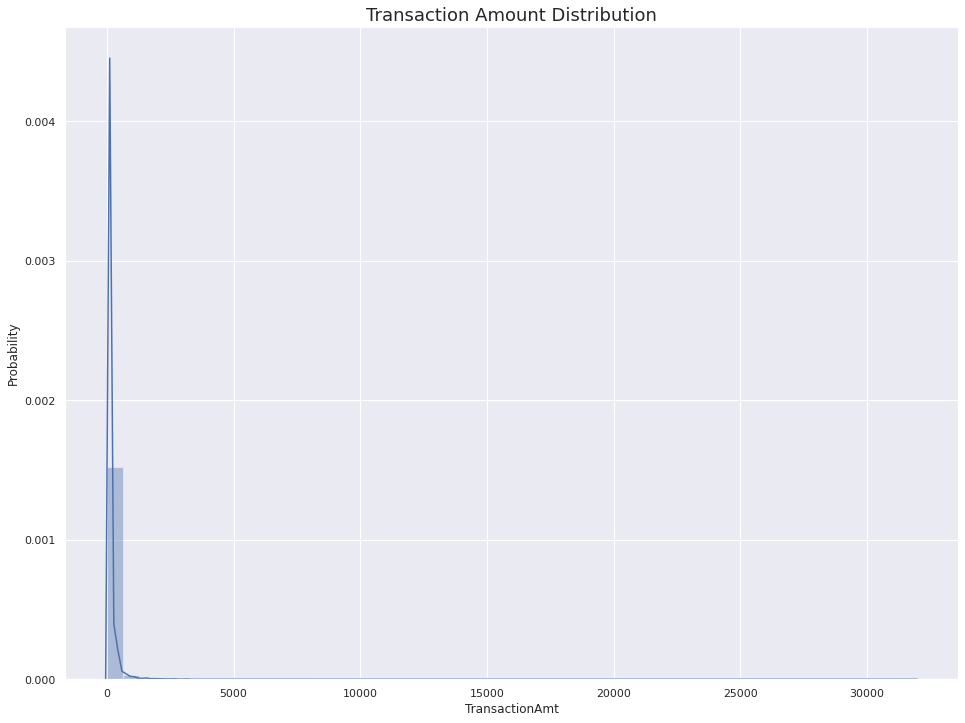

In [ ]:
# Distribution plot of Transaction Amount
plt.figure(figsize=(16,12))

sns.distplot(df['TransactionAmt'])
plt.title("Transaction Amount Distribution", fontsize=18)
plt.ylabel("Probability")

Heavily skewed to the right: not anything close to a normal distribution at all

Let's narrow down further:
See the distribute of the lower values (restrict to a narrower range)

Text(0, 0.5, 'Probability')

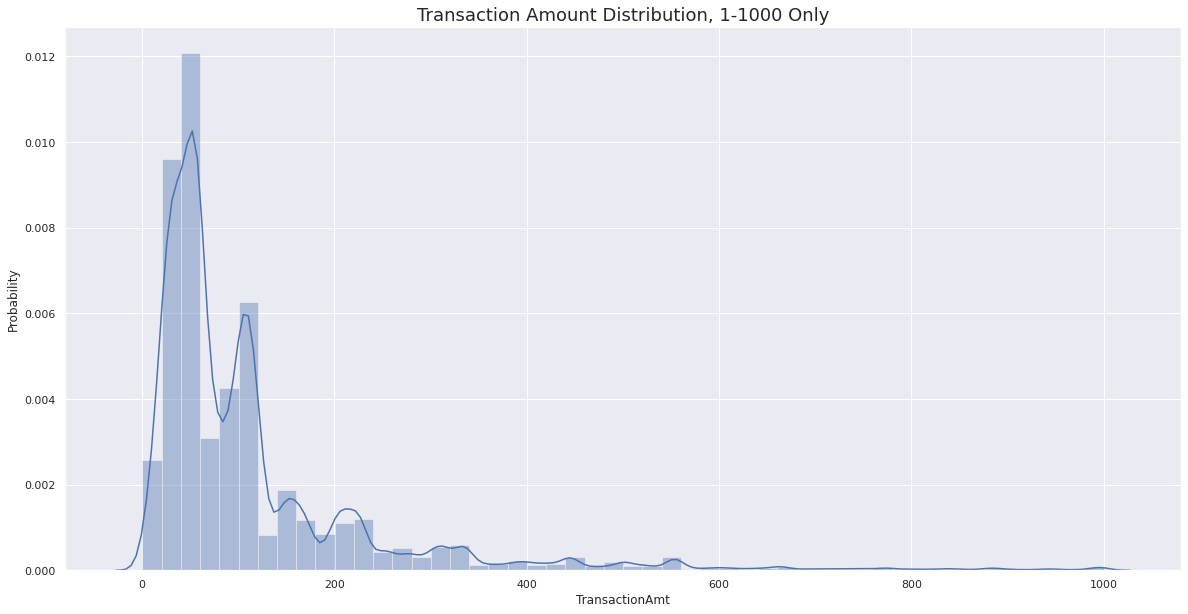

In [ ]:
# sns.distplot(df['TransactionAmt'])
sns.set(rc={"figure.figsize":(20, 10)}) # set the figure size to make things look bigger.
sns.distplot(df[df['TransactionAmt'] <= 1000]['TransactionAmt']) # (([[]]))
plt.title("Transaction Amount Distribution, 1-1000 Only", fontsize=18)
plt.ylabel("Probability")

We can find the log of the TransactionAmt column to make it distribution appear more centered and more like normal distribution. Could also try np.sqrt()

Some models are very sensitive to distribution of data. 

Text(0, 0.5, 'Probability')

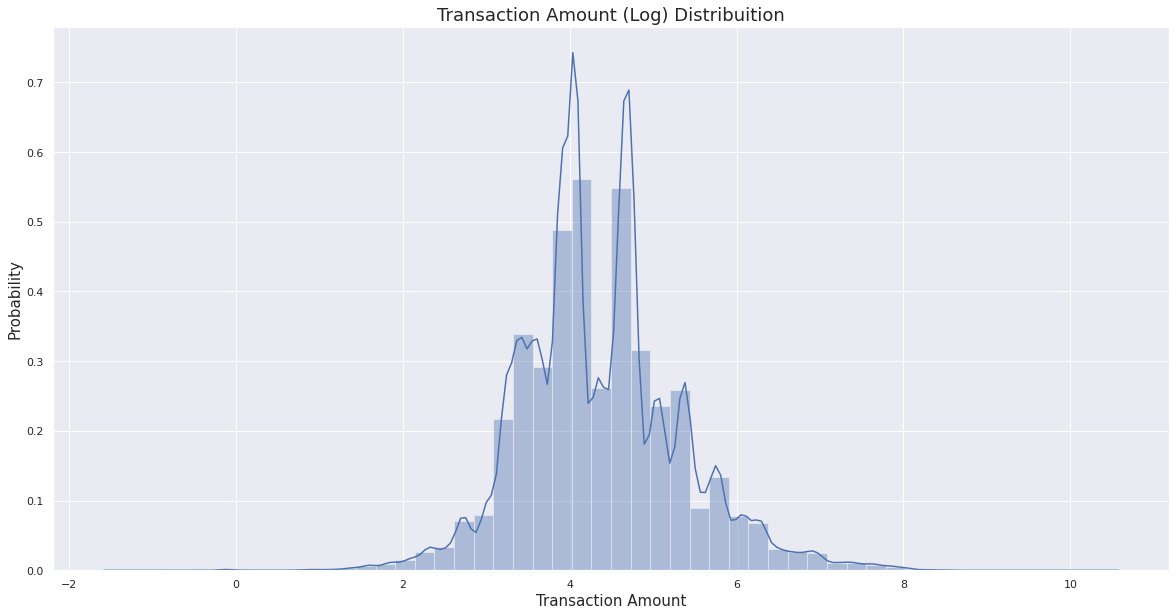

In [ ]:
sns.distplot(np.log(df['TransactionAmt']))
plt.title("Transaction Amount (Log) Distribuition", fontsize=18)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Probability", fontsize=15)

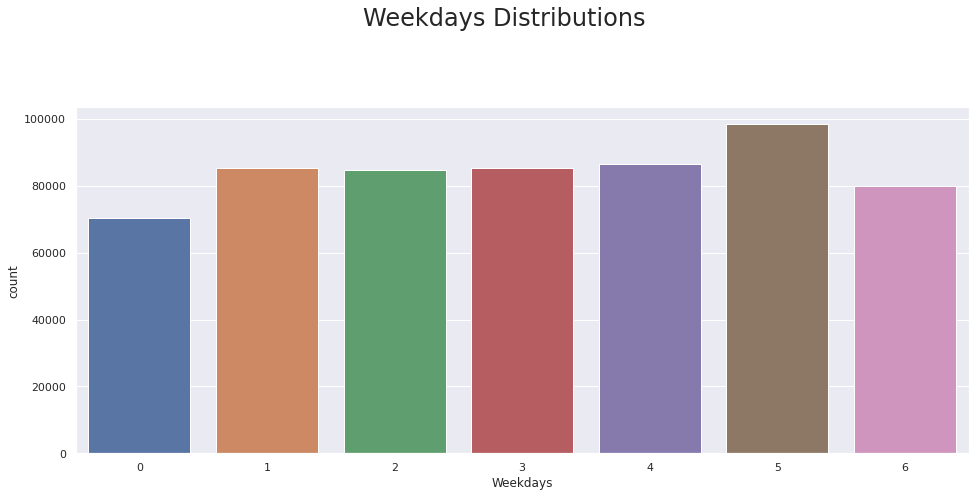

In [ ]:
plot_cat_with_amt(df, 'Weekdays')

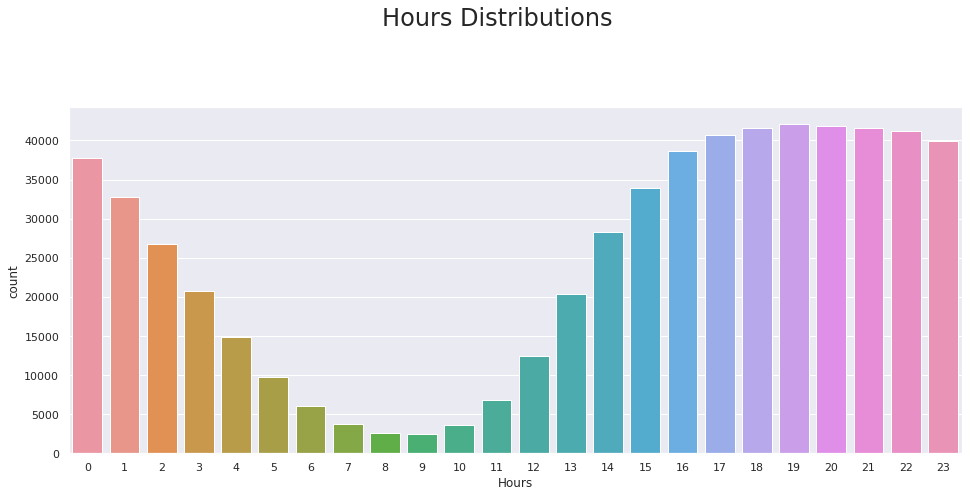

In [ ]:
plot_cat_with_amt(df, 'Hours')

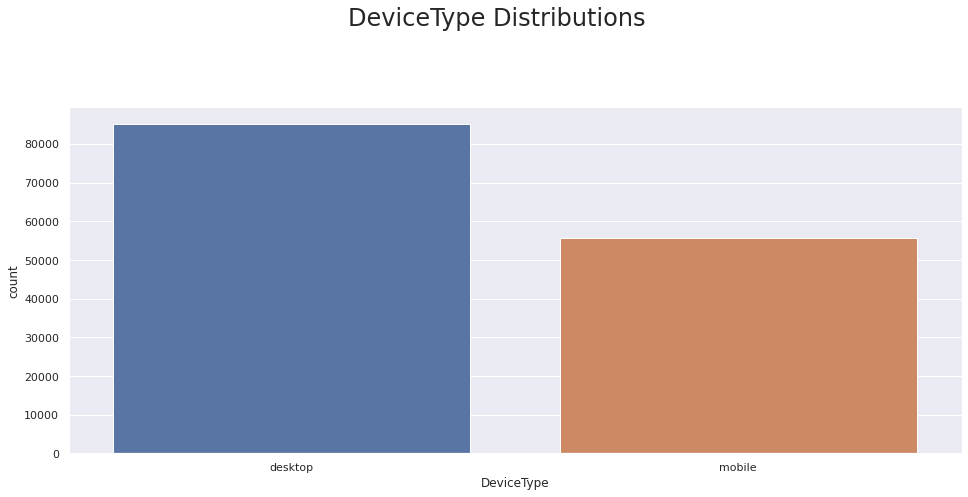

In [ ]:
plot_cat_with_amt(df, 'DeviceType')

# Reminder:
1. create a new col to np.log()

In [ ]:
pd.crosstab(df[col], df['isFraud'], normalize='index')

id29_table = df.groupby(["id_29"])["isFraud"].value_counts()
id29 = pd.DataFrame(id29_table)
id29

isFraud
id_29    isFraud         
Found    0          67099
         1           7827
NaN      0         440117
         1           9445
NotFound 0          62661
         1           3391

In [ ]:
def plot_cat_feat_dist(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(25, 18))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)

    g.set_title(f"{col} Distribution", fontsize=16)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
        
    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

    g1.set_title(f"{col} Distribution by Target Variable (isFraud) ", fontsize=16)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

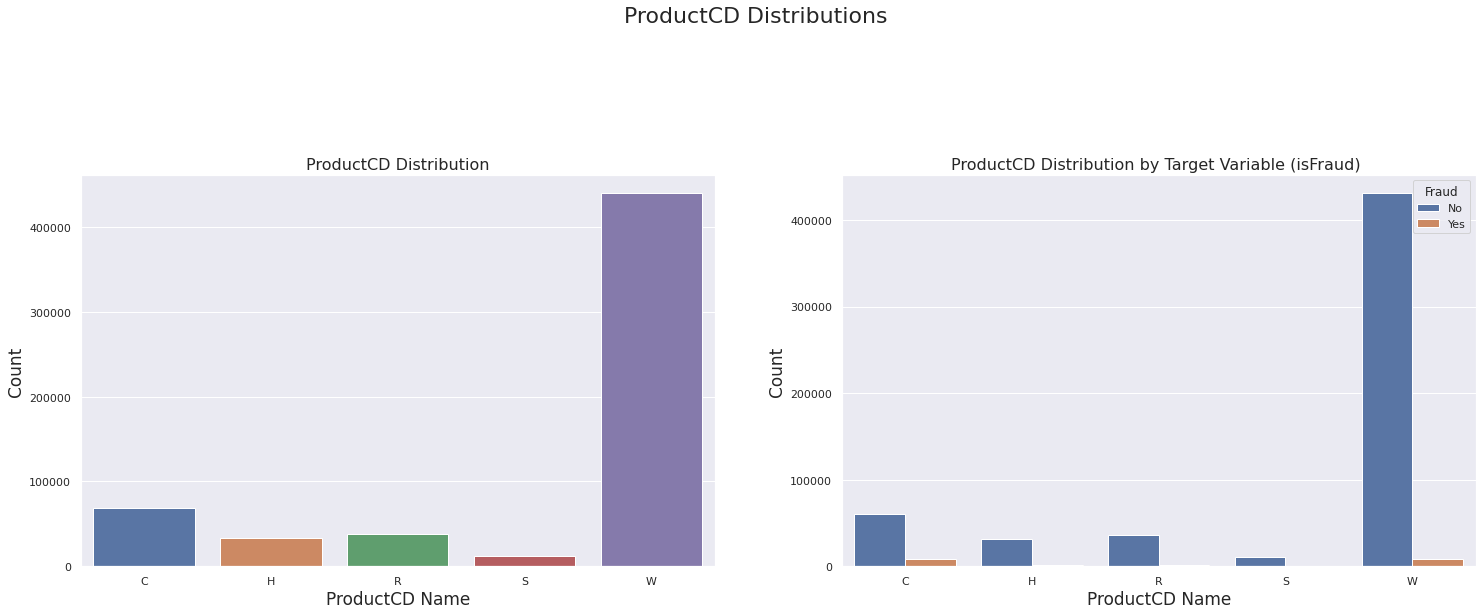

In [ ]:
plot_cat_feat_dist(df, "ProductCD")

In [ ]:
# Average fraud per transaction by ProductCD
df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

Some findings so far:

1. Fraud rate is highest for Product C and lowest (on average) for Product W

2. More transctions happen on Saturday than weekdays (which are more or less similar) except a low on Monday

3. As for ProductCD, A significantly high number of W's than everything else

In [ ]:
list(df.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

### Card Features

In [ ]:
df.groupby(["card4"])["isFraud"].mean()

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64



df['col2'] = stats.zscore(df['col2'])

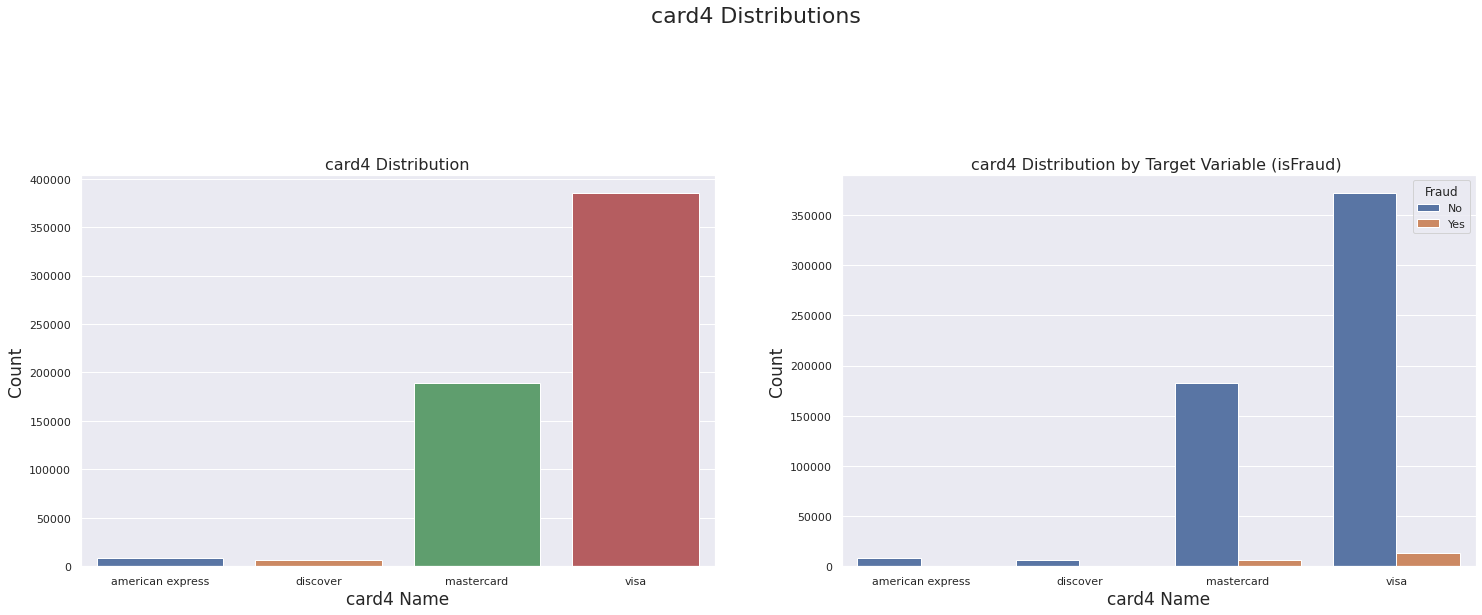

In [ ]:
plot_cat_feat_dist(df, "card4")

More cases for the Visa and Mastercard, but this could also be a matter of them having more card counts

In [ ]:
df.groupby(["card4"])["isFraud"].mean()

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64

Higher chance if you have the "discover" card for fruadulous cases. Mastercard and Visa do take more share of fraudulant cases but their percentages are both lower than "discover" cards.

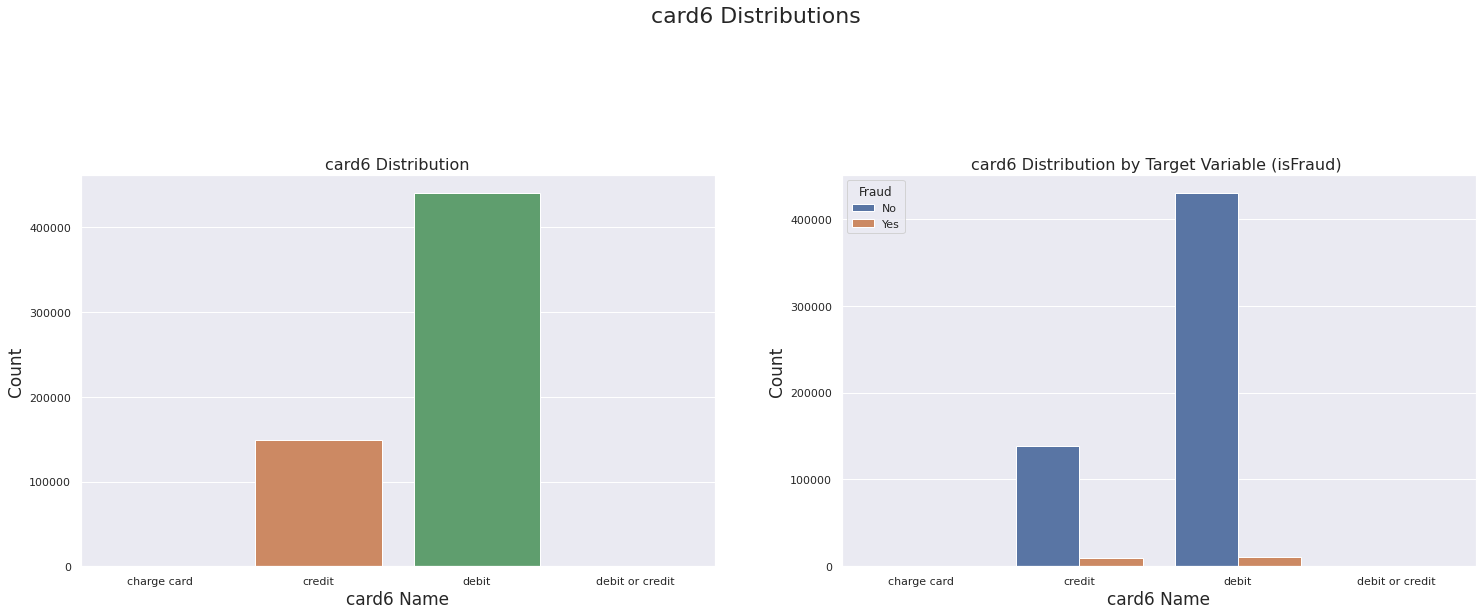

In [ ]:
plot_cat_feat_dist(df, "card6")

In [ ]:
# Average fraud per transaction by Card6
df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
Google            0.043496
Microsoft         0.053298
NoInf             0.029538
Others            0.025646
Yahoo Mail        0.022544
anonymous.com     0.023217
aol.com           0.021811
att.net           0.007439
bellsouth.net     0.027763
charter.net       0.030637
comcast.net       0.031187
cox.net           0.020818
earthlink.net     0.021401
icloud.com        0.031434
mail.com          0.189624
me.com            0.017740
optonline.net     0.016815
rocketmail.com    0.003012
sbcglobal.net     0.004040
verizon.net       0.008133
ymail.com         0.020868
Name: isFraud, dtype: float64

In [ ]:
df.columns.to_list()

### Email Domain

In [ ]:
df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df.loc[df['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df.loc[df['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df.loc[df.R_emaildomain.isin(df.R_emaildomain\
                                         .value_counts()[df.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df.R_emaildomain.fillna("NoInf", inplace=True)

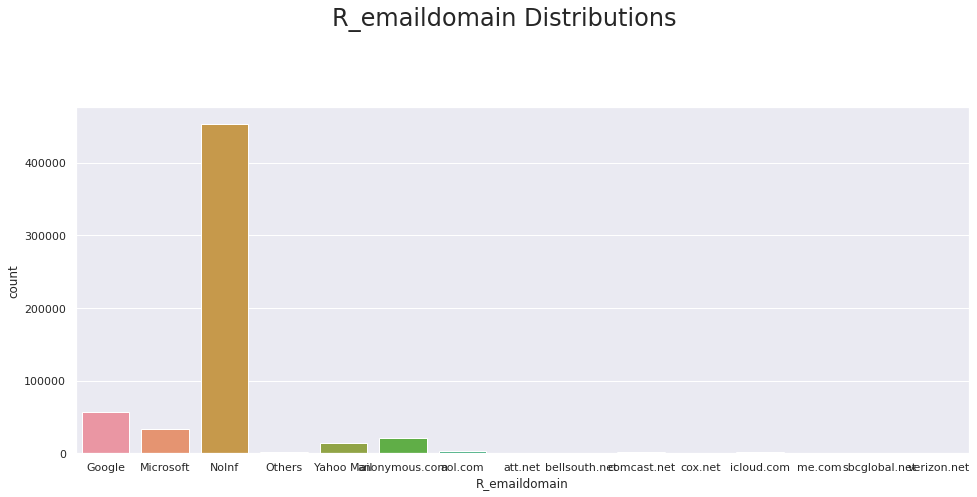

In [ ]:
plot_cat_with_amt(df, 'R_emaildomain')

#### Introducing Plotly 

(my personal favorite: very intuitive interface, easy to pick up; plot without big learning curve)

In [ ]:
#!pip install --upgrade plotly

In [ ]:
#!pip install --upgrade jupyter-dash

In [ ]:
import plotly.express as px

In [ ]:
"""
fig = px.histogram(df, x='R_emaildomain', text_auto='.2s',
            title="R_emaildomain")
fig.show()
"""

'\nfig = px.histogram(df, x=\'R_emaildomain\', text_auto=\'.2s\',\n            title="R_emaildomain")\nfig.show()\n'

In [ ]:
df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
Google           0.118986
Microsoft        0.080764
NoInf            0.020819
Others           0.050989
Yahoo Mail       0.046235
anonymous.com    0.029130
aol.com          0.034855
att.net          0.000000
bellsouth.net    0.004739
comcast.net      0.011589
cox.net          0.023965
icloud.com       0.128755
me.com           0.019784
sbcglobal.net    0.001812
verizon.net      0.000000
Name: isFraud, dtype: float64

Google and Microsoft and icloud have the largest amount of fraudulous percentage 

P-email Domain

In [ ]:
df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df.loc[df.P_emaildomain.isin(df.P_emaildomain\
                                         .value_counts()[df.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df.P_emaildomain.fillna("NoInf", inplace=True)

In [ ]:
fig = px.histogram(df, x='P_emaildomain', text_auto='.2s',
            title="P_emaildomain")
fig.show()

In [ ]:
df.groupby(['isFraud', "P_emaildomain"])['TransactionAmt'].sum()

isFraud  P_emaildomain 
0        Google                inf
         Microsoft             inf
         NoInf                 inf
         Others                inf
         Yahoo Mail            inf
         anonymous.com         inf
         aol.com               inf
         att.net               inf
         bellsouth.net         inf
         charter.net           inf
         comcast.net           inf
         cox.net               inf
         earthlink.net         inf
         icloud.com            inf
         mail.com          55136.0
         me.com                inf
         optonline.net         inf
         rocketmail.com        inf
         sbcglobal.net         inf
         verizon.net           inf
         ymail.com             inf
1        Google                inf
         Microsoft             inf
         NoInf                 inf
         Others            21072.0
         Yahoo Mail            inf
         anonymous.com         inf
         aol.com               

In [ ]:
# write down your own visualization code to see different aspects of the data

1. numeric: scatterplot, regression (lm) if you do the ggplot, boxplot, violinplot, heatmaps (correlation)
2. categorical: (sns) distplot (countplot), barplot (useful to take average first or sth)

SNS and / or PLOTLY

In [ ]:
"""
from scipy import stats
  
  
# Creating the data frame
details = {
    'col1': [1, 3, 5, 7, 9],
    'col2': [7, 4, 35, 14, 56]
}
  
# creating a Dataframe object
df = pd.DataFrame(details)

# Z-Score using scipy
df['col2'] = stats.zscore(df['col2'])
"""

In [ ]:
# transaction amt / group by card 1, [transaction amt] .transform(mean)
# transaction amt / group by card 4, [transaction amt] .transform(mean)
# transaction amt / group by card 1, [transaction amt] .transform(std)
# transaction amt / group by card 4, [transaction amt] .transform(std)


In [ ]:
plot()

In [ ]:
df.Hours.mean()

13.861922985741863

Fill N/As (in the data columns it would just be empty values or blank) for id columns:

1. Find the ID columns
2. fillna with mean or median. You decide. Why?
3. Some other ways to fill the na for numeric data?



# ID

In [ ]:
for col in ['id_12', 'id_15', 'id_16', 'id_28', 'id_29']:
    df[col] = df[col].fillna('NaN')

df.loc[df['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df.loc[df['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df.loc[df['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df.loc[df['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df['id_30'].fillna("NAN", inplace=True)

In [ ]:
df.loc[df['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df.loc[df['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df.loc[df['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df.loc[df['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df.loc[df['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df.loc[df['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df.loc[df['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'

https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html

In [ ]:
df['id_31'].str

df.loc[ [T F T T F ...], column_name ] = some_value

In [ ]:
df['id_31'].str.contains('ie', na=False)

0         False
1         False
2         False
3         False
4         False
          ...  
590535    False
590536    False
590537    False
590538    False
590539    False
Name: id_31, Length: 590540, dtype: bool

In [ ]:
df.id_31.value_counts() < 200

chrome 63.0                       False
mobile safari 11.0                False
mobile safari generic             False
ie 11.0 for desktop               False
safari generic                    False
chrome 62.0                       False
chrome 65.0                       False
chrome 64.0                       False
chrome 63.0 for android           False
chrome generic                    False
chrome 66.0                       False
edge 16.0                         False
chrome 64.0 for android           False
chrome 65.0 for android           False
firefox 57.0                      False
mobile safari 10.0                False
chrome 66.0 for android           False
chrome 62.0 for android           False
edge 15.0                         False
chrome generic for android        False
firefox 59.0                      False
samsung browser 6.2               False
firefox 58.0                      False
chrome 49.0                       False
firefox                           False


In [ ]:
df.id_31.value_counts()[df.id_31.value_counts() < 200]

chrome 58.0                       188
firefox 48.0                      179
chrome 66.0 for ios               159
chrome 52.0 for android           152
Samsung/SM-G532M                  150
chrome 50.0 for android           145
opera 49.0                        138
chrome 59.0                       133
firefox 56.0                      126
safari 10.0                       111
firefox generic                   110
samsung browser 7.0               101
android browser 4.0               100
chrome 56.0                        98
mobile safari uiwebview            97
chrome 57.0                        94
chrome 57.0 for android            87
opera                              83
chrome 54.0 for android            82
Generic/Android 7.0                81
chrome 65.0 for ios                79
opera generic                      78
edge 17.0                          74
chrome 43.0 for android            72
chrome 46.0 for android            69
chrome 55.0                        64
edge 13.0   

In [ ]:
df.id_31.value_counts()[df.id_31.value_counts() < 200].index

Index(['chrome 58.0', 'firefox 48.0', 'chrome 66.0 for ios',
       'chrome 52.0 for android', 'Samsung/SM-G532M',
       'chrome 50.0 for android', 'opera 49.0', 'chrome 59.0', 'firefox 56.0',
       'safari 10.0', 'firefox generic', 'samsung browser 7.0',
       'android browser 4.0', 'chrome 56.0', 'mobile safari uiwebview',
       'chrome 57.0', 'chrome 57.0 for android', 'opera',
       'chrome 54.0 for android', 'Generic/Android 7.0', 'chrome 65.0 for ios',
       'opera generic', 'edge 17.0', 'chrome 43.0 for android',
       'chrome 46.0 for android', 'chrome 55.0', 'edge 13.0',
       'chrome 62.0 for ios', 'edge', 'Generic/Android', 'ie', 'chrome 51.0',
       'google search application 49.0', 'google search application 48.0',
       'opera 52.0', 'mobile safari 8.0', 'chrome 49.0 for android',
       'Samsung/SM-G531H', 'opera 51.0', 'opera 53.0', 'chrome 64.0 for ios',
       'chrome 51.0 for android', 'samsung browser 5.4', 'safari 9.0',
       'chrome 53.0 for android', '

In [ ]:
df.id_31.isin(df.id_31.value_counts()[df.id_31.value_counts() < 200].index)

0         False
1         False
2         False
3         False
4         False
          ...  
590535    False
590536    False
590537    False
590538    False
590539    False
Name: id_31, Length: 590540, dtype: bool

In [ ]:
df.loc[df.id_31.isin(df.id_31.value_counts()[df.id_31.value_counts() < 200].index), 'id_31'] = "Others"

df['id_31'].fillna("NAN", inplace=True)

In [ ]:
from scipy import stats
  
  
# Creating the data frame
details = {
    'col1': [1, 3, 5, 7, 9],
    'col2': [7, 4, 35, 14, 56]
}
  
# creating a Dataframe object
demo = pd.DataFrame(details)
  
# Z-Score using scipy
demo['col2'] = stats.zscore(demo['col2'])

In [ ]:
demo

col1      col2
0     1 -0.824387
1     3 -0.977052
2     5  0.600480
3     7 -0.468171
4     9  1.669130

### Significance Tests

Chi-Squared Test

Chi-Square test tells if the entire variable is useful or not.

First let's separate columns by their types:
1. cat_columns
2. binary_columns
3. num_columns

In [ ]:
cat_columns = df.select_dtypes(include=['object']).columns
len(cat_columns)

binary_columns = [col for col in df.columns if df[col].nunique() == 2]
len(binary_columns)

num_columns = [col for col in df.columns if (col not in cat_columns) & (col not in binary_columns)]
len(num_columns)

395

In [ ]:
print(f"Number of columns \n\ncategorical: {len(cat_columns)}\nbinary: {len(binary_columns)} \nnumerical: {len(num_columns)}")

Number of columns 

categorical: 57
binary: 26 
numerical: 395


Import Library

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
# See the odds (the ratio of the 1 class to the 0 class) 
ctab = pd.crosstab(df['ProductCD'], df['isFraud'].astype('category')) # nothing but a few 
ctab

isFraud         0     1
ProductCD              
C           60511  8008
H           31450  1574
R           36273  1426
S           10942   686
W          430701  8969

In [ ]:
cat_columns = cat_columns.to_list() + binary_columns

Chi_squared tests have to do with categorical columns (variables) to see if the observed values for the groups within that column are any different from the expected.

In [ ]:
# significance value
alpha = 0.05

significant_categorical_variables = []

for col in cat_columns:  
    # Create a crosstab table
    temp = pd.crosstab(df[col], df['isFraud'].astype('category'))
    
    # Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
    stat, p, dof, expected = chi2_contingency(temp)
    
    # Determine whether to reject or keep your null hypothesis
    print(col.ljust(40), ',  chisquared=%.5f,   p-value=%.5f' % (stat, p))
    if p <= alpha:
        significant_categorical_variables.append(col)
    else:
        continue

ProductCD                                ,  chisquared=16742.17153,   p-value=0.00000
card4                                    ,  chisquared=364.87414,   p-value=0.00000
card6                                    ,  chisquared=5957.03229,   p-value=0.00000
P_emaildomain                            ,  chisquared=2652.43233,   p-value=0.00000
R_emaildomain                            ,  chisquared=17297.50859,   p-value=0.00000
M1                                       ,  chisquared=0.00000,   p-value=1.00000
M2                                       ,  chisquared=438.61321,   p-value=0.00000
M3                                       ,  chisquared=477.66057,   p-value=0.00000
M4                                       ,  chisquared=6450.44798,   p-value=0.00000
M5                                       ,  chisquared=242.42169,   p-value=0.00000
M6                                       ,  chisquared=227.96414,   p-value=0.00000
M7                                       ,  chisquared=11.25610,   p-va

In [ ]:
ctab.columns = ctab.columns.add_categories('odds')
ctab['odds'] = ctab[1]/ctab[0]
ctab

isFraud         0     1      odds
ProductCD                        
C           60511  8008  0.132340
H           31450  1574  0.050048
R           36273  1426  0.039313
S           10942   686  0.062694
W          430701  8969  0.020824

Odds ratio simply means dividing the odds by 

In [ ]:
ctab.columns = ctab.columns.add_categories('odds_ratio')
ctab['odds_ratio'] = ctab['odds'] / (ctab[1].sum()/ctab[0].sum())
ctab

isFraud         0     1      odds  odds_ratio
ProductCD                                    
C           60511  8008  0.132340    3.649871
H           31450  1574  0.050048    1.380295
R           36273  1426  0.039313    1.084236
S           10942   686  0.062694    1.729080
W          430701  8969  0.020824    0.574323

Highers odds ratio implies more chance of fraud in that category.

Farther away it is from 1.0 (both directions) more important the variable is.

### ANOVA test 

ANOVA test is a test of variance. However, the test statistic is actually the sample mean. 

First we need to understand what is it we are dealing with (we can't do any testing or technique without knowing WHAT we are working with in the first place. Sometimes, Statistics contains many terms that you kind of understand. 

But no, this is not the best approach. We need to know exactly what we are working with:
1. mean is a number (take the average of a bunch of numbers)
2. variance is similar to a range (measures spread; how spread out is the data) 

This is counterintuitive yet it is true in this case. We are determining if the variance between different groups (within the column / variable of interest) is statisically significant by comparing the sample means, not variance itself. 

Assumptions:

1. Samples are independent.

2. Each sample is from a normally distributed population.

3. The population standard deviations of the groups are all equal. This property is called homoscedasticity.


ANOVA deals with numerical variables / columns whereas CHi-squared tests deal with categorical

In [ ]:
num_columns

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V

### Your turn to code the ANOVA test:

1. follow the general directions listed below

2. refer back to the chi-squared test implementation

3. when in doubt, break code down and google things you don't know

In [ ]:
# import library f_oneway from scipy.stats
from scipy.stats import f_oneway
# set significance value
sig_val = 0.05
# set a list variable (for storing items later)
significant_numerical_variables = []
# for loop (hint: only numerical columns) 
for col in num_columns:
    # if number of unique values for this column exceeds 50 (or some other number you choose)
    if df[col].nunique() > 50: 
      # use f_oneway function. Don't forget to dropna for the 2 inputs (the df with isfraud==1 and isfraud==0). What 2 outputs does f_oneway return? 
      # Name those 2 outputs using some reasonable names
      F, p = f_oneway(df[df.isFraud == 1][col].dropna(), 
                      df[df.isFraud == 0][col].dropna())
      # print them out. Also be sure to print out the column name. 
      print(col.ljust(40), ',   F-statistic=%.5f, p=%.5f' % (F, p), df.loc[:, col].nunique())
      # if <some_condition> (hint: has to do with p-value vs significance value):
      if p <= sig_val:
        significant_numerical_variables.append(col)
          # append the column into the list variable above


TransactionID                            ,   F-statistic=118.52652, p=0.00000 590540
TransactionDT                            ,   F-statistic=101.40691, p=0.00000 573349
TransactionAmt                           ,   F-statistic=75.67718, p=0.00000 8195
card1                                    ,   F-statistic=109.88932, p=0.00000 13553
card2                                    ,   F-statistic=6.67558, p=0.00977 500
card3                                    ,   F-statistic=14336.21578, p=0.00000 114
card5                                    ,   F-statistic=661.82659, p=0.00000 119
addr1                                    ,   F-statistic=16.43435, p=0.00005 332
addr2                                    ,   F-statistic=485.06660, p=0.00000 74
dist1                                    ,   F-statistic=110.42966, p=0.00000 2412
dist2                                    ,   F-statistic=13.66508, p=0.00022 1699
C1                                       ,   F-statistic=552.37693, p=0.00000 1495
C2      

Interpret the results

In [ ]:
df.card5.nunique()

fill na

scaling 

In [ ]:
# fill na

count     590540
unique         3
top          NaN
freq      461200
Name: id_16, dtype: object

In [ ]:
# try some standard scaling for numerical variables 

Drop columns:

There is 1 obvious column that can be dropped because it does not add any useful information. What is it? 

Once you identify it, drop it. 

Also drop the date column

In [ ]:
# df.drop([...], axis=1) or df.drop(..., inplace=True)

In [ ]:
# delete the date column because we made some new time variables

In [ ]:
from pandas_summary import DataFrameSummary

df_summary = DataFrameSummary(df)
df_summary.summary()

TransactionID   isFraud   TransactionDT TransactionAmt  \
count              590540.0  590540.0        590540.0       590540.0   
mean              3282269.5   0.03499  7372311.310116            NaN   
std           170474.358321  0.183755   4617223.64654            0.0   
min               2987000.0       0.0         86400.0      -1.382812   
25%              3134634.75       0.0      3027057.75       3.767578   
50%               3282269.5       0.0       7306527.5       4.230469   
75%              3429904.25       0.0      11246620.0       4.828125   
max               3577539.0       1.0      15811131.0         10.375   
counts               590540    590540          590540         590540   
uniques              590540         2          573349           2516   
missing                   0         0               0              0   
missing_perc             0%        0%              0%             0%   
types               numeric      bool         numeric        numeric   

                ProductCD        card1     card2     card3        card4  \
count                 NaN     590540.0  581607.0  588975.0          NaN   
mean                  NaN  9898.734658       NaN       NaN          NaN   
std                   NaN  4901.170153       NaN       0.0          NaN   
min                   NaN       1000.0     100.0     100.0          NaN   
25%                   NaN       6019.0     214.0     150.0          NaN   
50%                   NaN       9678.0     361.0     150.0          NaN   
75%                   NaN      14184.0     512.0     150.0          NaN   
max                   NaN      18396.0     600.0     231.0          NaN   
counts             590540       590540    581607    588975       588963   
uniques                 5        13553       500       114            4   
missing                 0            0      8933      1565         1577   
missing_perc           0%           0%     1.51%     0.27%        0.27%   
types         categorical      numeric   numeric   numeric  categorical   

                 card5        card6     addr1     addr2     dist1    dist2  \
count         586281.0          NaN  524834.0  524834.0  238269.0  37627.0   
mean               NaN          NaN       NaN       NaN       NaN      inf   
std                0.0          NaN       NaN       0.0       NaN      inf   
min              100.0          NaN     100.0      10.0       0.0      0.0   
25%              166.0          NaN     204.0      87.0       3.0      7.0   
50%              226.0          NaN     299.0      87.0       8.0     37.0   
75%              226.0          NaN     330.0      87.0      24.0    206.0   
max              237.0          NaN     540.0     102.0   10288.0  11624.0   
counts          586281       588969    524834    524834    238269    37627   
uniques            119            4       332        74      2412     1699   
missing           4259         1571     65706     65706    352271   552913   
missing_perc     0.72%        0.27%    11.13%    11.13%    59.65%   93.63%   
types          numeric  categorical   numeric   numeric   numeric  numeric   

             P_emaildomain R_emaildomain        C1        C2        C3  \
count                  NaN           NaN  590540.0  590540.0  590540.0   
mean                   NaN           NaN       NaN       NaN       0.0   
std                    NaN           NaN       NaN       NaN       0.0   
min                    NaN           NaN       0.0       0.0       0.0   
25%                    NaN           NaN       1.0       1.0       0.0   
50%                    NaN           NaN       1.0       1.0       0.0   
75%                    NaN           NaN       3.0       3.0       0.0   
max                    NaN           NaN    4684.0    5692.0      26.0   
counts              590540        590540    590540    590540    590540   
uniques                 21            15      1495      1167        27   
missing                  0             0       

In [ ]:
df.drop(columns=["TransactionID", "Date"], inplace=True)

### feature engineering

In [7]:
cat_columns = df.select_dtypes(include=['object']).columns
print(len(cat_columns))
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
print(len(binary_columns))
num_columns = [col for col in df.columns if (col not in cat_columns) & (col not in binary_columns)]
print(len(num_columns))

31
26
395


use np.log to transform the transactionAmt.

Why? 

Because transactionAmt has few very large values and many lower values causing a big discrepency. 

In [8]:
df['TransactionAmt'] = np.log(df['TransactionAmt'])

let's make a special feature

Transaction amount - mean of transaction (use np.nanmean to avoid the N/A values)

In [9]:
df['Trans_min_mean'] = df['TransactionAmt'] - np.nanmean(df['TransactionAmt'], dtype="float64")

Create another one (use np.nanstd())

This is to create a z-score 

Why Standardize your Data?

https://builtin.com/data-science/when-and-why-standardize-your-data


In [10]:
df['Trans_min_std']  = df['Trans_min_mean'] / np.nanstd(df['TransactionAmt'].astype("float64"), dtype="float64")

In [11]:
df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_std_card1']  = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
df['TransactionAmt_to_std_card4']  = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

Fill na values and scale V columns


In [12]:
df.columns.get_loc("V1"), df.columns.get_loc("V339")

(55, 393)

In [13]:
filter_col = df.columns[55:394]
filter_col

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=339)

Getting the V columns from data frame

In [14]:
for col in filter_col:
    df[col] = df[col].fillna((df[col].mean())) #
    df[col] = (minmax_scale(df[col], feature_range=(0,1))) # minmax scale to convert the scale to 0 to 1

There are 2 ways to do scaling + PCA:

1. Transform the Dataset and then work with a model
2. Build a pipeline so that the scaling + PCA becomes part of the model itself. We will see how to do that with the Scikit-learn package

In [15]:
# initialize function to perform PCA
def perform_PCA(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    return df

In [16]:
v_subset = df.loc[:,filter_col]
v_subset.head()

V1        V2        V3        V4        V5        V6        V7  \
0  1.000000  0.125000  0.111111  0.166667  0.166667  0.111111  0.111111   
1  0.999945  0.130651  0.119786  0.141076  0.146165  0.116187  0.119208   
2  1.000000  0.125000  0.111111  0.166667  0.166667  0.111111  0.111111   
3  0.999945  0.130651  0.119786  0.141076  0.146165  0.116187  0.119208   
4  0.999945  0.130651  0.119786  0.141076  0.146165  0.116187  0.119208   

         V8        V9       V10       V11       V12       V13     V14  \
0  0.125000  0.125000  0.000000  0.000000  0.333333  0.166667  1.0000   
1  0.128463  0.130191  0.115979  0.095797  0.000000  0.000000  1.0000   
2  0.125000  0.125000  0.000000  0.000000  0.333333  0.166667  1.0000   
3  0.128463  0.130191  0.115979  0.095797  0.333333  0.166667  1.0000   
4  0.128463  0.130191  0.115979  0.095797  0.186570  0.099861  0.9995   

        V15       V16       V17       V18       V19       V20       V21  \
0  0.000000  0.000000  0.000000  0.000000  0.142857  0.066667  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.142857  0.066667  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.142857  0.066667  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.142857  0.066667  0.000000   
4  0.017477  0.008231  0.008936  0.009024  0.116624  0.056523  0.025937   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.000000  0.076923  0.076923  0.142857  0.076923  0.000000  0.000000   
1  0.000000  0.076923  0.076923  0.142857  0.076923  0.000000  0.000000   
2  0.000000  0.076923  0.076923  0.142857  0.076923  0.000000  0.000000   
3  0.000000  0.076923  0.076923  0.142857  0.076923  0.000000  0.000000   
4  0.016537  0.079599  0.081392  0.139666  0.076003  0.000194  0.000207   

        V29      V30       V31       V32      V33       V34       V35  \
0  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000  0.180865   
1  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000  0.000000   
2  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000  0.333333   
3  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000  0.333333   
4  0.077568  0.04516  0.020109  0.009494  0.01867  0.010704  0.180865   

       V36       V37       V38       V39       V40       V41       V42  \
0  0.11584  0.020520  0.021526  0.011072  0.007381  0.999269  0.019515   
1  0.00000  0.018519  0.018519  0.000000  0.000000  1.000000  0.000000   
2  0.20000  0.018519  0.018519  0.000000  0.000000  1.000000  0.000000   
3  0.20000  0.018519  0.018519  0.000000  0.000000  1.000000  0.000000   
4  0.11584  0.020520  0.021526  0.011072  0.007381  0.999269  0.019515   

        V43       V44       V45       V46       V47       V48       V49  \
0  0.021118  0.022581  0.023350  0.170381  0.086543  0.076635  0.079545   
1  0.000000  0.020833  0.020833  0.166667  0.083333  0.000000  0.000000   
2  0.000000  0.020833  0.020833  0.166667  0.083333  0.000000  0.000000   
3  0.000000  0.020833  0.020833  0.166667  0.083333  0.000000  0.000000   
4  0.021118  0.022581  0.023350  0.170381  0.086543  0.076635  0.079545   

        V50      V51       V52       V53       V54       V55       V56  \
0  0.032949  0.02843  0.015225  0.200000  0.166667  0.058824  0.019608   
1  0.000000  0.00000  0.000000  0.000000  0.000000  0.058824  0.019608   
2  0.000000  0.00000  0.000000  0.200000  0.166667  0.058824  0.019608   
3  0.000000  0.00000  0.000000  0.200000  0.166667  0.058824  0.019608   
4  0.032949  0.02843  0.015225  0.115517  0.103330  0.062804  0.021980   

        V57       V58       V59       V60       V61       V62       V63  \
0  0.000000  0.000000  0.000000  0.000000  0.166667  0.100000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.166667  0.100000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.166667  0.100000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.166667  0.100000  0.000000   
4  0.021385  0.013245  0.008402  0.008909  0.138297  0.086756 

In [17]:
for col in filter_col:
    df[col] = df[col].fillna((df[col].median())) #

In [18]:
df = perform_PCA(df, filter_col, prefix='PCA_V_', n_components=30)

In [ ]:
df = reduce_mem_usage(df)

Mem. usage decreased to 788.18 Mb (29.6% reduction)


In [ ]:
# Perform PCA for filter columns (for next time)

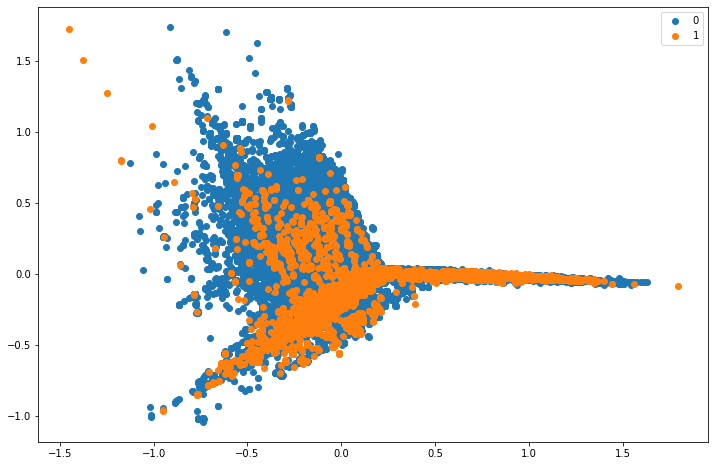

In [19]:
# Plot first 2 PCA features and colour by target variable
plt.figure(figsize=(12, 8));
groups = df.groupby("isFraud")
for name, group in groups:
    plt.scatter(group["PCA_V_0"], group["PCA_V_1"], label=name)
plt.legend()
plt.show()

Points represent data that is pointing to the principle components -- 

PCA - cut down # of columns -- make new varaibles that capture a similar amount of info (usually lower) in terms of variance 

each variable is mixture of all the different info from the columns

PC1 - orthogonal 


Encoding is to convert data from one form to another. Most of Machine learning algorithms can not handle categorical values unless we convert them to numerical values. 

Many algorithm’s performances vary based on how Categorical columns are encoded.

Convert categorical variabels to numbers for machine to understand


**Frequency Encoding**

Use frequency of the categories as labels. 

In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on nature of the data.

A: 30% ——> Group A becomes the number associated with the 30%
B: 20%
C: 25%
D: 25% 

In [20]:
# Frequecny encoding variables
frequency_encoded_variables = []
for col in cat_columns:
    if df[col].nunique() > 30:
        print(col, df[col].nunique())
        frequency_encoded_variables.append(col)

P_emaildomain 59
R_emaildomain 60
id_30 75
id_31 130
id_33 260
DeviceInfo 1786


In [21]:
cat_columns = cat_columns.to_list()

In [22]:
# Frequecny enocde the variables
for variable in tqdm(frequency_encoded_variables):
    # group by frequency 
    fq = df.groupby(variable).size()/len(df)    
    # mapping values to dataframe 
    df.loc[:, "{}".format(variable)] = df[variable].map(fq)   
    cat_columns.remove(variable)

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


In [23]:
float16_cols = list(df.select_dtypes(include=['float16']).columns)
new_type = dict((col,'float') for col in float16_cols)
df = df.astype(new_type)

In [24]:
df.to_parquet("need_woe.parquet")

In [ ]:
#!unzip /content/need_woe.parquet.zip

In [25]:
data = pd.read_parquet("/content/need_woe.parquet")

In [26]:
data.drop(columns=["TransactionDT"], axis=1, inplace=True)

Could try:
1. Weight of Evidence Encoding (for logistic regression)
2. Mean encoding with smoothing to balance out the weights

https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02#:~:text=implement%20as%20below%3A-,Weight%20of%20Evidence%20Encoding,the%20credit%20and%20financial%20industry

Don't do:
1. label encoding 

red - 0
blue - 1
green - 2
white - 3

label encoding

3 * blue can't be white - mathematical patterns that don't exist

In [27]:
# Mean encode the variables with the smoothing done

def mean_encoding(df, target, col, weight):
  mean = df[target].mean()
  agg = df.groupby([col])[target].agg(["count", "mean"]) # returns a dictionary mapping of count and mean
  counts, means = agg["count"], agg["mean"]
  smooth = (counts * means + weight * mean) / (counts + weight) # smooth is also a dictionary
  df.loc[:, f"{col}_smec"] = df[col].map(smooth)
  df.drop(columns=[col], inplace=True)
  return df

red - average of is fraud for red - .34
blue - average of is fraud for blue - .67

applying weight -- to make the numbers closer to the global average - overall average of is fraud

higher the weight closer to the average

to make sure groups are not too different - removing variance - model will perform more consistently

model learns from the training data set - applies patterns it learns to new data - test set

In [28]:
cat_columns = data.select_dtypes(include=['object']).columns
len(cat_columns)

binary_columns = [col for col in data.columns if data[col].nunique() == 2]
len(binary_columns)

19

Split data even more into train and testing data

In [29]:
for col in cat_columns:
  data = mean_encoding(data, "isFraud", col, 100)

Split the data:


x:  our data with independent variables

y:  the targt variable: isFraud

In [30]:
# Split the y variable series and x variables dataset
x = data.drop(['isFraud'],axis=1)
y = data.isFraud.astype(bool)

Train Test Split

In [31]:
# Split the dataset into the training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [32]:
data.to_parquet("fe_data.parquet")

Model training

In [33]:
%%time
# Define the model
xgb = XGBClassifier(nthread = -1, random_state=0)

# Train the model
xgb.fit(x_train, y_train)
xgb

XGBoostError: ignored

In [ ]:
# Prediction
y_pred_xgb = xgb.predict(x_test)
y_prob_pred_xgb = xgb.predict_proba(x_test)
y_prob_pred_xgb = [x[1] for x in y_prob_pred_xgb]
print("Y predicted : ", y_pred_xgb)
print("Y probability predicted : ", y_prob_pred_xgb[:5])

Confusion Matrix 

In [34]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier().fit(x_train, y_train)


In [35]:
y_pred=clf.predict(x_test)
y_prob_pred = clf.predict_proba(x_test)
y_prob_pred = [x[1] for x in y_prob_pred]
print("Y predicted : ", y_pred)
print("Y probability predicted : ", y_prob_pred[:5])

Y predicted :  [False False False ... False False False]
Y probability predicted :  [0.002584739083601334, 0.02531342127843328, 0.015606473527529694, 0.02736152888974251, 0.0032134197200157856]


In [36]:
from sklearn.ensemble import HistGradientBoostingRegressor
clfe = HistGradientBoostingRegressor().fit(x_train, y_train)


In [38]:
y_pred_reg=clfe.predict(x_test)
print("Y predicted : ", y_pred_reg)

Y predicted :  [ 0.00378997  0.02414461  0.01482661 ...  0.00850962 -0.00768559
  0.29239417]


In [ ]:
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    print("\n Accuracy Score : ",accuracy_score(y_actual, y_predicted))
    print("\n AUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\n Confusion Matrix : \n",confusion_matrix(y_actual, y_predicted))
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))

    print("\n ROC curve : \n")
    plot_roc_curve(model, x_test, y_actual)
    plt.show() 

    print("\n PR curve : \n")
    plot_precision_recall_curve(model, x_test, y_actual)
    plt.show() 


 Accuracy Score :  0.981023018480261

 AUC Score :  0.9420473118280145

 Confusion Matrix : 
 [[170726    315]
 [  3047   3074]]

 Classification Report : 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99    171041
        True       0.91      0.50      0.65      6121

    accuracy                           0.98    177162
   macro avg       0.94      0.75      0.82    177162
weighted avg       0.98      0.98      0.98    177162


 ROC curve : 



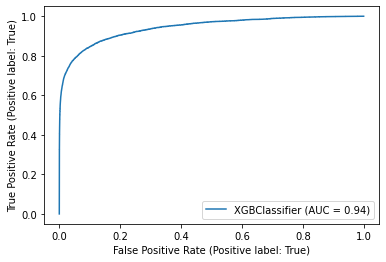


 PR curve : 



ValueError: ignored

In [ ]:
compute_evaluation_metric(xgb, x_test, y_test, y_pred_xgb, y_prob_pred_xgb)

Not using accuracy to evaluate model performance on test set -- we only have around 1% of fradulent cases 

if model makes everything 0 - then it will have 99% accuracy - but its a bad model 

AUC is to help us decide a threshold to decide which data points will be assigned 0 or 1 - for examples greater than 
.5 we make 1, but want to find the best threshold

Check out discord for precision, recall, f-1 score, confusion matrix, etc - measuring by these instead of the accuracy

find out best models to run - logistic regression, xgboost

train own model and evaluate on the test set